# Modeling Gene Expression from Promoter Sequence

## Setup

### Import Packages

In [1]:
from collections import Counter
from itertools import product
import os
from pathlib import Path
import sys

from Bio.Align import AlignInfo, MultipleSeqAlignment
import Bio.motifs as motifs
from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
sys.path.append('../bitome-kb')
from bitome.core import Bitome
from bitome.features import TranscriptionUnit

### Load Bitome Knowledgebase

In [2]:
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

### Load Expression Data

We just want wild-type samples

Linear Model for Regulation (Y = S*A' + B; can we get just b? how does it related to X = S*A)

For each iModulon:
- get its A vector
- verify the sign (decide if maximum activity = maximum regulation)
- linear normalize the A vector so that lowest activity is 0
- how much is absolute expression changing due to iModulon activity? Must convert from A-vector to abs expression

Validation:
- what is variation in basal PRECISE? Regulation should be subtracted off, so it shouldn't be much variable
- Does canonical repression/activation coincide with transformation direction?
- Does model perform better?

In [3]:
log_tpm_df = pd.read_csv('data/precise2/log_tpm_qc.csv', index_col=0)
X_basal_reg = pd.read_csv('data/X_basal_reg.csv', index_col=0)
X_basal_reg_dir = pd.read_csv('data/X_basal_reg_dir.csv', index_col=0)
metadata_df = pd.read_csv('data/precise2/metadata_qc.csv', index_col=0)
S_binarized = pd.read_csv('data/precise2/S_binarized.csv', index_col=0)

In [4]:
wt_index = metadata_df[
    (metadata_df['Strain Description'] == 'Escherichia coli K-12 MG1655') &
    (metadata_df['Base Media'] == 'M9') & 
    (metadata_df['pH'] == 7.0) & 
    (metadata_df['Temperature (C)'] == 37) &
    (metadata_df['project_id'] != 'abx_media') &
    (metadata_df['project_id'] != 'eep')
].index

log_tpm_wt = log_tpm_df[wt_index]
log_tpm_wt_mean = log_tpm_wt.mean(axis=1)
log_tpm_wt_std = log_tpm_wt.std(axis=1)
log_tpm_wt_med = log_tpm_wt.median(axis=1)

basal_reg_med = X_basal_reg.median(axis=1)
basal_reg_dir_med = X_basal_reg_dir.median(axis=1)

Store the genes that are in the iModulons so we can try out prediction without them

In [5]:
gene_membs = S_binarized.sum(axis=1)
im_genes = gene_membs[gene_membs > 0].index

## Prepare X Matrices

### Feature Matrix based on Strainware Calculated Features

In [ ]:
X_strainware_df = pd.read_csv('data/features_avg.csv')
X_strainware_df = X_strainware_df.set_index('ID')
X_strainware_df = pd.DataFrame(
    StandardScaler().fit_transform(X_strainware_df),
    columns=X_strainware_df.columns,
    index=X_strainware_df.index
)

no_expression_data = set(X_strainware_df.index) - set(log_tpm_wt.index)
X_strainware_df = X_strainware_df.drop(index=no_expression_data)
X_strainware_df.head()

In [10]:
sw_cols_to_keep = [
    'strand', 'TU_length', 'leading', 'lagging', 'terminus', 'USR_AT', 'DSR_AG',
    'distToOrigin', 'distToTer', 'Ori/(Ori+Ter)', 'orderInOperon'
]
X_sw_small_df = X_strainware_df[sw_cols_to_keep]

### One-Hot-Encoded Promoter Sequence

In [5]:
def tss_consensus_from_tus(tus, n_up, n_down):
    
    # extract the sequences for each tss
    sequences = []
    for tu in tus:
        
        strand = tu.location.strand
        if strand == 1:
            if tu.tss is not None:
                tss = tu.tss
            else:
                tss = tu.location.start.position
            # define the sequence feature location to extract the sequence around this TSS
            seq_loc = FeatureLocation(
                int(tss - n_up - 1),
                int(tss + n_down),
                int(strand)
            )
        else:
            if tu.tss is not None:
                tss = tu.tss
            else:
                tss = tu.location.end.position
            # define the sequence feature location to extract the sequence around this TSS
            seq_loc = FeatureLocation(
                int(tss - n_down - 1),
                int(tss + n_up),
                int(strand)
            )

        sequence = seq_loc.extract(bitome.sequence)
        sequences.append(sequence)

    # create a motif with Biopython and get a consensus sequence from that; return the degenerate consensus
    motif = motifs.create(sequences)

    pwm = motif.counts
    base_rows = []

    for base in 'ATCG':
        base_row = pd.Series(pwm[base], index=[f'{pos}_{base}' for pos in np.arange(-n_up, n_down+1)])
        base_rows.append(base_row)

    full_row = pd.concat(base_rows)
    full_row = full_row / len(sequences)
    
    return full_row

def create_X(locus_tags, tu_tups, N_UP, N_DOWN, scale=False):
    X = pd.DataFrame([tss_consensus_from_tus(tu_tup, N_UP, N_DOWN) for tu_tup in tu_tups], index=locus_tags)
    if scale:
        X = pd.DataFrame(
            StandardScaler().fit_transform(X),
            columns=X.columns,
            index=X.index
        )
    return X

In [6]:
locus_tags = []
tu_tups = []
for locus_tag in log_tpm_wt.index:

    genes = [g for g in bitome.genes if g.locus_tag == locus_tag]
    if genes:
        gene = genes[0]
        gene_tus = [tu for tu in gene.transcription_units]
        if gene_tus:
            locus_tags.append(locus_tag)
            tu_tups.append(gene_tus)

In [7]:
N_UP = 40
N_DOWN = 10

X_onehot_df = create_X(locus_tags, tu_tups, N_UP, N_DOWN)

In [8]:
X_oh_train, X_oh_lockbox = train_test_split(X_onehot_df, test_size=0.1, random_state=42)

### Cherry-Picked One-Hot

In [11]:
# see lower in the notebook for how we got these
key_bps = [2, 1, 0, -21, -12, -15, 3, -8, -32, -10]
key_bp_cols = [f'{bp}_{base}' for bp, base in product(key_bps, list('ATGC'))]

X_oh_train_cp = X_oh_train[key_bp_cols]

### Combined One-Hot and Strainware

In [15]:
X_strainware_df_all = pd.read_csv('data/features_avg.csv').set_index('ID')
no_expression_data = set(X_strainware_df_all.index) - set(log_tpm_df.index)
X_strainware_df_all = X_strainware_df_all.drop(index=no_expression_data)

X_all = X_strainware_df_all.merge(X_oh_train, left_index=True, right_index=True)
X_SW_OH_small = X_sw_small_df.merge(X_oh_train, left_index=True, right_index=True)

X_all = pd.DataFrame(
    StandardScaler().fit_transform(X_all),
    columns=X_all.columns,
    index=X_all.index
)

### Without iModulon Genes

In [16]:
X_oh_train_no_im = X_oh_train.drop(index=set(im_genes).intersection(X_oh_train.index))
X_sw_no_im = X_strainware_df.drop(index=set(im_genes).intersection(X_strainware_df.index))
X_all_no_im = X_all.drop(index=set(im_genes).intersection(X_all.index))
X_sw_small_no_im = X_sw_small_df.drop(index=set(im_genes).intersection(X_sw_small_df.index))
X_SW_OH_small_no_im = X_SW_OH_small.drop(index=set(im_genes).intersection(X_SW_OH_small.index))

## Model, Feature, Target Assessment

In [45]:
Xy_to_try = {
    'One-hot': (X_oh_train, log_tpm_wt_med[X_oh_train.index]),
    # 'One-hot Cherry-picked': (X_oh_train_cp, log_tpm_wt_med[X_oh_train.index]),
    #'One-hot Basal': (X_oh_train, basal_reg_med[X_oh_train.index]),
    #'One-hot Basal Dir': (X_oh_train, basal_reg_dir_med[X_oh_train.index])
#     'Strainware': (X_strainware_df, log_tpm_wt_med[X_strainware_df.index]),
#     'SW + OH': (X_all, log_tpm_wt_med[X_all.index]),
#     'SWsmall': (X_sw_small_df, log_tpm_wt_med[X_sw_small_df.index]),
#     'SWsmall + OH': (X_SW_OH_small, log_tpm_wt_med[X_SW_OH_small.index]),
#     'One-hot (no iM)': (X_oh_train_no_im, log_tpm_wt_med[X_oh_train_no_im.index]),
#     'Strainware (no iM)': (X_sw_no_im, log_tpm_wt_med[X_sw_no_im.index]),
#     'SW + OH (no iM)': (X_all_no_im, log_tpm_wt_med[X_all_no_im.index]),
#     'SWsmall (no iM)': (X_sw_small_no_im, log_tpm_wt_med[X_sw_small_no_im.index]),
#     'SWsmall + OH (no iM)': (X_SW_OH_small_no_im, log_tpm_wt_med[X_SW_OH_small_no_im.index])
}

In [9]:
models_to_try = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(
        random_state=42,
        n_jobs=4
    ),
    'NN': MLPRegressor()
}

In [14]:
result_df = pd.DataFrame(
    columns=['model', 'xy', 'train_r2', 'val_r2']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for X_name, (X, y_to_use) in Xy_to_try.items():
        print(f'{model_name}: {X_name}')
        
        cv_result = cross_validate(
            model,
            X,
            y=y_to_use,
            cv=N_CV,
            scoring='r2',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'xy': [X_name] * N_CV,
                'train_r2': cv_result['train_score'],
                'val_r2': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

ElasticNet
ElasticNet: One-hot


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


ElasticNet: One-hot Cherry-picked
ElasticNet: One-hot Basal


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ElasticNet: One-hot Basal Dir
SVR
SVR: One-hot


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: One-hot Cherry-picked


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: One-hot Basal


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: One-hot Basal Dir


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF
RF: One-hot


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: One-hot Cherry-picked


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: One-hot Basal


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: One-hot Basal Dir


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NN
NN: One-hot


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NN: One-hot Cherry-picked


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NN: One-hot Basal


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NN: One-hot Basal Dir


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.6s finished


In [56]:
result_df.to_csv('data/GE_onehot_basal_initial.csv')

In [57]:
result_df = pd.read_csv('data/GE_onehot_basal_initial.csv', index_col=0)

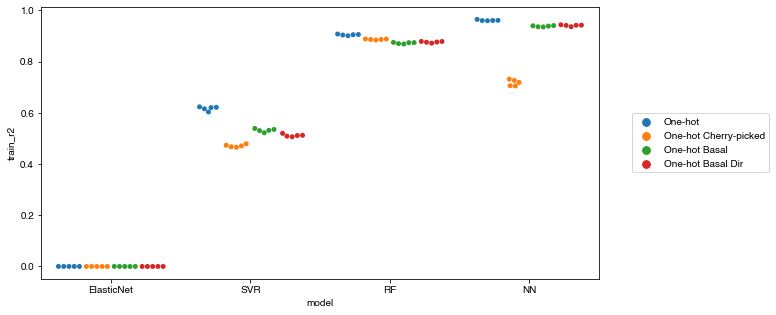

In [15]:
_, ax = plt.subplots(figsize=(10, 5))
sns.swarmplot(x='model', y='train_r2', data=result_df, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

(0.0, 1.0)

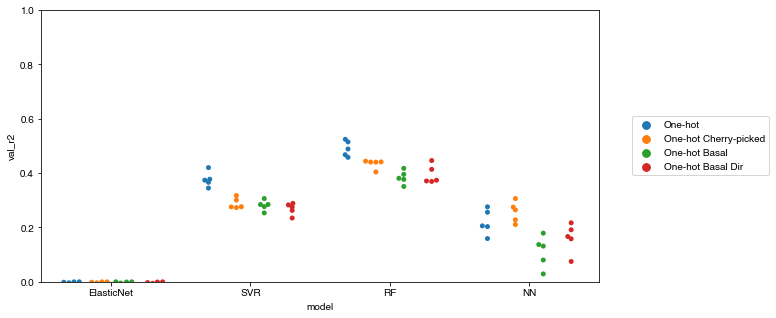

In [16]:
_, ax = plt.subplots(figsize=(10, 5))
sns.swarmplot(x='model', y='val_r2', data=result_df, hue='xy', dodge=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_ylim(0, 1)

## Hyperoptimization

Need to reduce overfitting; doesn't seem to be much difference between the different targets, so let's stick with median

In [54]:
hyperopt_XY = {
    'OH - Med': (X_oh_train, log_tpm_wt_med[X_oh_train.index])
#     'SW - Med': (X_strainware_df, log_tpm_wt_med[X_strainware_df.index]),
#     'All - Med': (X_all, log_tpm_wt_med[X_all.index])
}

In [61]:
hyperopt_models = {
    'ElasticNet': {
        'model': ElasticNet(selection='random'),
        'param_dists': {
            'alpha': np.logspace(-3, 3, num=7),
            'l1_ratio': np.linspace(0, 1, num=10)
        }
    },
    'SVR': {
        'model': SVR(),
        'param_dists': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': np.arange(2, 6),
            'C': np.logspace(-4, 1, num=10)
        }
    },
    'RF': {
        'model': RandomForestRegressor(),
        'param_dists': {
            'n_estimators': [25, 50, 100, 250],
            'max_depth': np.arange(2, 20)
        }
    },
    'NN': {
        'model': MLPRegressor(max_iter=50),
        'param_dists': {
            'hidden_layer_sizes': [(32), (32, 32), (32, 32, 32), (32, 32, 32, 32)],
            'activation': ['relu', 'tanh'],
            'alpha': np.logspace(-6, -1, num=10)
        }
    }
}

In [62]:
hyperopt_results = {}

for model_name, model_hyperopt_dict in hyperopt_models.items():

    hyperopt_results[model_name] = {}
    
    for X_name, (X, y) in hyperopt_XY.items():
        print(f'{model_name}: {X_name}')

        random_search_hyperopt = RandomizedSearchCV(
            model_hyperopt_dict['model'],
            model_hyperopt_dict['param_dists'],
            n_iter=25,
            scoring='r2',
            n_jobs=4,
            cv=5,
            verbose=3,
            return_train_score=True
        )

        random_search_hyperopt.fit(X, y)

        hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
            by='mean_test_score',
            ascending=False
        )
        hyperopt_results[model_name][X_name] = hyperopt_results_df

ElasticNet: OH - Med
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   16.9s finished
/Users/cam/.virtualenvs/strainware-s/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10296.698547592108, tolerance: 2.746308034365785
  positive)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: OH - Med
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 11.3min finished


RF: OH - Med
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  7.1min finished


NN: OH - Med
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.2min finished
/Users/cam/.virtualenvs/strainware-s/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [67]:
hyperopt_results['RF']['OH - Med'][
    ['param_n_estimators', 'param_max_depth', 'mean_test_score', 'mean_train_score']
]

,param_n_estimators,param_max_depth,mean_test_score,mean_train_score
3,250,16,0.504239,0.908794
6,250,13,0.501744,0.895927
21,100,17,0.499399,0.907207
22,100,15,0.499382,0.904974
16,250,12,0.496972,0.882865
4,50,18,0.493750,0.904165
12,250,11,0.491019,0.861386
1,50,11,0.487988,0.855764
0,50,16,0.487029,0.902578
24,100,11,0.486786,0.859433


In [ ]:
# combine all the hyperopt results into a DF, making sure to add a 'model' column to track which model is which
dfs_with_models = []
for model_name, model_hyperopt_df in hyperopt_results.items():
    model_hyperopt_df['model'] = [model_name] * model_hyperopt_df.shape[0]
    dfs_with_models.append(model_hyperopt_df)
    
hyperopt_result_df = pd.concat(dfs_with_models, axis=0, ignore_index=True)
hyperopt_result_df.to_csv('data/GE_hyperopt_1.csv')

## One-Hot Deep Dive for Nucleotide Importance

In [10]:
cv_result_oh = cross_validate(
    models_to_try['RF'],
    X_oh_train,
    y=log_tpm_wt_med[X_oh_train.index],
    cv=5,
    scoring='r2',
    return_train_score=True,
    return_estimator=True,
    verbose=1,
    n_jobs=4
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.6s finished


In [25]:
estimators = cv_result_oh['estimator']
feat_imps = [est.feature_importances_ for est in estimators]

feat_bps = []
bases = []
imps = []

for feat, feat_imps in zip(X_oh_train.columns, zip(*feat_imps)):
    bp, base = feat.split('_')

    feat_bps += [int(bp)] * len(feat_imps)
    bases += [base] * len(feat_imps)
    imps += list(feat_imps)
    
feat_imp_cv_df = pd.DataFrame(data={'bp': feat_bps, 'imp': imps, 'base': bases})

Text(0, 0.5, 'RF Importance')

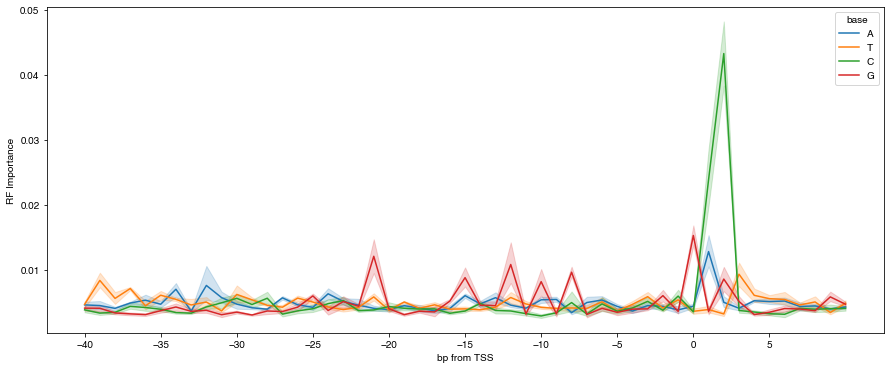

In [27]:
_, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='bp', y='imp', hue='base', data=feat_imp_cv_df, ax=ax)
ax.set_xticks(np.arange(-40, 10, 5))
ax.set_xlabel('bp from TSS')
ax.set_ylabel('RF Importance')

### Overall Importance by Base

In [32]:
feat_imp_cv_df.head()

,bp,imp,base
0,-40,0.003891,A
1,-40,0.005015,A
2,-40,0.004358,A
3,-40,0.005269,A
4,-40,0.004230,A


In [42]:
bp_imps = []
for bp in feat_imp_cv_df['bp'].unique():
    bp_df = feat_imp_cv_df[feat_imp_cv_df['bp'] == bp]
    imp_sum = bp_df['imp'].sum()
    bp_imps.append((bp, imp_sum))

In [46]:
[bp for bp, imp in sorted(bp_imps, key=lambda tup: tup[1], reverse=True)[:10]]

[2, 1, 0, -21, -12, -15, 3, -8, -32, -10]

## BW25113 tabA Sequence Investigation

We know from https://ecocyc.org/gene?orgid=ECOLI&id=G7883#tab=TU that tabA has a TSS at 
4474834

We know from bioinfo.ccs.usherbrooke.ca/BW25113.html that BW25113 has a substitution at that exact spot: A -> G

We know from BW25113 iModulon that tabA is more expressed in BW25113

### Manually Construct the One-Hot Encoded Sequences for Each Case

In [10]:
bitome.get_gene('tabA').locus_tag

'b4252'

In [11]:
bitome.get_gene('tabA').location

FeatureLocation(ExactPosition(4474861), ExactPosition(4475314), strand=1)

In [12]:
# make a dummy TU because RegulonDB doesn't have an explicit TU
tabA_TU = TranscriptionUnit(
    'tabA', 
    'tabA',
    (4474834, 4475314),
    1,
    bitome.sequence,
    tss=4474834,
    tts=4475314,
    name='tabA'
)

In [13]:
tabA_X = create_X(['tabA_MG', 'tabA_BW'], [[tabA_TU], [tabA_TU]], 40, 10)
# make the BW mutation
tabA_X.loc['tabA_BW', '0_A'] = 0
tabA_X.loc['tabA_BW', '0_G'] = 1

In [16]:
wt_mod, bw_mod = np.array([est.predict(tabA_X) for est in cv_result_oh['estimator']]).mean(axis=0)

In [17]:
wt_true = log_tpm_wt_med.loc['b4252']

In [18]:
bw_index = metadata_df[
    (metadata_df['Strain Description'] == 'Escherichia coli BW25113') &
    (metadata_df['Base Media'] == 'M9') & 
    (metadata_df['pH'] == 7.0) & 
    (metadata_df['Temperature (C)'] == 37) &
    (metadata_df['project_id'] != 'abx_media')
].index

log_tpm_bw = log_tpm_df[bw_index]
log_tpm_bw_mean = log_tpm_bw.mean(axis=1)
log_tpm_bw_std = log_tpm_bw.std(axis=1)
log_tpm_bw_med = log_tpm_bw.median(axis=1)

In [19]:
bw_true = log_tpm_bw_med.loc['b4252']

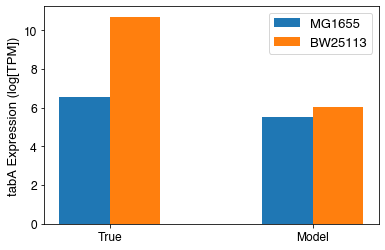

In [20]:
_, ax = plt.subplots()
ax.bar([-0.125, 0.875], [wt_true, wt_mod], width=0.25, align='center', label='MG1655')
ax.bar([0.125, 1.125], [bw_true, bw_mod], width=0.25, align='center', label='BW25113')
ax.set_xticks([0, 1])
ax.set_xticklabels(['True', 'Model'])
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('tabA Expression (log[TPM])', fontsize=13)
ax.legend(fontsize=13)

### Contextualizing Prediction

We get a slight rise in expression predicted from this change; where does this predicted change stand in the space of all possible permutations in this region. 

Let's try all of the other point mutations possible

In [21]:
# back-calculate the MG sequence
tabA_mg = [tup[1] for tup in sorted([(int(col.split('_')[0]), col.split('_')[1]) for 
        col in list(tabA_X.loc['tabA_MG'][tabA_X.loc['tabA_MG'] == 1].index)]
      )]

In [22]:
mut_seq_X = pd.DataFrame(columns=tabA_X.columns)

for i, base in zip(np.arange(-40, 11), tabA_mg):
    other_bases = list(set(['A', 'T', 'C', 'G']) - set([base]))
    for other_base in other_bases:
        mut_seq_X.loc[f'{i}_{other_base}', :] = tabA_X.loc['tabA_MG']
        mut_seq_X.loc[f'{i}_{other_base}', f'{i}_{base}'] = 0
        mut_seq_X.loc[f'{i}_{other_base}', f'{i}_{other_base}'] = 1

In [23]:
avg_preds = pd.Series(
    np.array([est.predict(mut_seq_X) for est in cv_result_oh['estimator']]).mean(axis=0), index=mut_seq_X.index
).sort_values()

/Users/cam/.virtualenvs/strainware/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


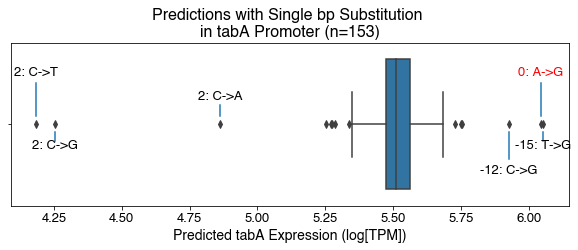

In [24]:
_, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(avg_preds, ax=ax)
ax.set_xlabel('Predicted tabA Expression (log[TPM])', fontsize=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Predictions with Single bp Substitution \nin tabA Promoter (n=153)', fontsize=16)

outliers = avg_preds[(avg_preds < 5) | (avg_preds > 5.76)]
up = True
more = True
for i, outlier in enumerate(outliers.iteritems()):
    orig_base = tabA_mg[np.where(np.arange(-40, 11) == int(outlier[0][:-2]))[0][0]]
    if up and more:
        y = -0.3
    elif up:
        y = -0.15
    elif more:
        y = 0.3
    else:
        y = 0.15
    if outlier[0][:-2] == '0':
        color = 'red'
    else:
        color = 'black'
    ax.text(
        outlier[1], y, f'{outlier[0][:-2]}: {orig_base}->{outlier[0][-1]}', ha='center', fontsize=13, color=color
    )
    if y < 0 and more:
        ax.axvline(outlier[1], ymin=0.55, ymax=0.75)
    elif y < 0:
        ax.axvline(outlier[1], ymin=0.55, ymax=0.62)
    elif more:
        ax.axvline(outlier[1], ymin=0.29, ymax=0.45)
    else:
        ax.axvline(outlier[1], ymin=0.4, ymax=0.45)
    up = not up
    if i % 2 == 0:
        more = not more

## MG1655 yddG Mutation Investigation

We know of a C->T mutation 73 bp upstream of yddG start codon

### Manually Construct the One-Hot Encoded Sequences for Each Case

In [13]:
yddG = bitome.get_gene('yddG')
yddG.locus_tag

'b1473'

In [14]:
yddG.location

FeatureLocation(ExactPosition(1546287), ExactPosition(1547169), strand=-1)

In [22]:
mut_pos = yddG.location.end.position + 73

In [20]:
yddG_tu = yddG.transcription_units[0]
yddG_tu.tss

1547205

So let's figure out where this mutation is relative to the TSS

In [24]:
yddG_tu.tss - mut_pos

-37

Fascinating, mutation right in the -35 box. Let's see what the model thinks.

In [35]:
yddG_X = create_X(['yddG_MG', 'yddG_mut'], [[yddG_tu], [yddG_tu]], 40, 10)
# make the mutation
yddG_X.loc['yddG_mut', '-37_C'] = 0
yddG_X.loc['yddG_mut', '-37_T'] = 1

In [36]:
yddG_wt, yddG_mut = np.array([est.predict(yddG_X) for est in cv_result_oh['estimator']]).mean(axis=0)

In [37]:
yddG_wt

5.280681035826352

### Contextualizing Prediction

We get a slight rise in expression predicted from this change; where does this predicted change stand in the space of all possible permutations in this region. 

Let's try all of the other point mutations possible

In [39]:
# back-calculate the MG sequence
yddG_mg_seq = [tup[1] for tup in sorted([(int(col.split('_')[0]), col.split('_')[1]) for 
        col in list(yddG_X.loc['yddG_MG'][yddG_X.loc['yddG_MG'] == 1].index)]
      )]

In [42]:
mut_seq_X_yddg = pd.DataFrame(columns=yddG_X.columns)

for i, base in zip(np.arange(-40, 11), yddG_mg_seq):
    other_bases = list(set(['A', 'T', 'C', 'G']) - set([base]))
    for other_base in other_bases:
        mut_seq_X_yddg.loc[f'{i}_{other_base}', :] = yddG_X.loc['yddG_MG']
        mut_seq_X_yddg.loc[f'{i}_{other_base}', f'{i}_{base}'] = 0
        mut_seq_X_yddg.loc[f'{i}_{other_base}', f'{i}_{other_base}'] = 1

In [44]:
avg_preds_yddG = pd.Series(
    np.array([est.predict(mut_seq_X_yddg) for est in cv_result_oh['estimator']]).mean(axis=0), index=mut_seq_X_yddg.index
).sort_values()

/Users/cam/.virtualenvs/strainware/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


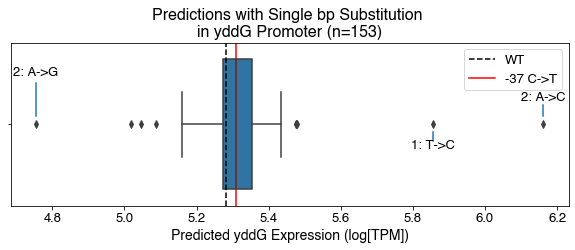

In [55]:
_, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(avg_preds_yddG, ax=ax)
ax.set_xlabel('Predicted yddG Expression (log[TPM])', fontsize=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Predictions with Single bp Substitution \nin yddG Promoter (n=153)', fontsize=16)

ax.axvline(yddG_wt, linestyle='--', color='black', label='WT')
ax.axvline(yddG_mut, linestyle='-', color='red', label='-37 C->T')

ax.legend(fontsize=13)

outliers = avg_preds_yddG[(avg_preds_yddG < 5) | (avg_preds_yddG > 5.76)]
up = True
more = True
for i, outlier in enumerate(outliers.iteritems()):
    orig_base = yddG_mg_seq[np.where(np.arange(-40, 11) == int(outlier[0][:-2]))[0][0]]
    if up and more:
        y = -0.3
    elif up:
        y = -0.15
    elif more:
        y = 0.3
    else:
        y = 0.15
    if outlier[0][:-2] == '0':
        color = 'red'
    else:
        color = 'black'
    ax.text(
        outlier[1], y, f'{outlier[0][:-2]}: {orig_base}->{outlier[0][-1]}', ha='center', fontsize=13, color=color
    )
    if y < 0 and more:
        ax.axvline(outlier[1], ymin=0.55, ymax=0.75)
    elif y < 0:
        ax.axvline(outlier[1], ymin=0.55, ymax=0.62)
    elif more:
        ax.axvline(outlier[1], ymin=0.29, ymax=0.45)
    else:
        ax.axvline(outlier[1], ymin=0.4, ymax=0.45)
    up = not up
    if i % 2 == 0:
        more = not more

## Predicting Specific Expression Profiles

Is there any particular condition that is more predictable than others in PRECISE 2.0?

In [25]:
# collapse replicates to reduce redundancy
log_tpm_wt_rep_avg = pd.DataFrame(index=log_tpm_df.index)
for wt_cond, cond_df in metadata_df.loc[wt_index].groupby('condition_id'):
    sample_idx = cond_df.index
    log_tpm_wt_rep_avg[wt_cond] = log_tpm_df[sample_idx].mean(axis=1)

log_tpm_wt_rep_avg

,ade_glc,arg_cytd,arg_sbt,cytd_rib,dbcn_glc,gth,leu_glcr,met_glc,nitr_031,no3_anaero,...,wt_gly,wt_glyc,wt_h2o2,wt_nacl,wt_no_te,wt_pH7_lactate,wt_pq,wt_thr,wt_trp,wt_xyl
Geneid,,,,,,,,,,,,,,,,,,,,,
b0001,9.207095,8.551308,7.009731,7.546483,11.692306,10.143227,8.712009,8.952670,3.875606,10.020075,...,7.081947,8.371840,7.969109,7.793461,8.454426,8.721566,4.824370,5.422601,11.238297,10.734366
b0002,9.823007,10.025159,11.218724,6.454778,9.937320,7.671177,11.532080,10.092982,10.274328,10.137293,...,10.710109,8.859692,10.589764,7.818364,10.525447,10.734435,7.344612,7.944751,8.908076,11.465243
b0003,9.476312,9.751598,11.019801,7.352172,9.866250,7.100703,10.900574,9.723523,9.971115,9.937512,...,10.089400,8.942716,10.198297,8.243572,10.396104,10.109732,7.852484,8.353247,8.690675,11.345587
b0004,9.669819,9.789268,10.844418,7.232195,9.676576,6.714389,11.051361,9.822305,9.382138,9.787984,...,9.909386,9.046092,10.117657,7.020739,9.821885,10.008619,7.098671,7.996143,9.067561,11.319964
b0005,6.572308,6.078767,6.881811,3.919780,9.327396,4.729103,7.266025,6.701451,5.260919,5.802628,...,6.856102,6.003095,6.598921,3.584438,5.964272,6.291281,4.415351,5.950551,5.311455,7.723208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,4.085752,3.953141,3.502750,3.773241,3.568533,4.062706,3.412841,3.054846,4.373618,4.121290,...,4.945428,3.964981,4.000711,3.924426,4.449518,3.902940,4.395041,5.027224,3.839193,3.871074
b4400,3.031334,2.660548,2.616002,2.662922,1.719769,3.001162,2.305921,2.070473,2.866123,3.049605,...,2.635246,2.637030,3.009624,2.057021,2.652446,2.368132,3.076808,3.582934,3.020880,3.231693
b4401,9.436446,9.356762,9.475495,11.787911,9.623319,10.473660,9.523462,9.030332,10.674538,9.815893,...,8.991644,9.489155,9.493743,11.160049,10.066909,9.653972,11.434707,9.184508,9.642667,8.109052


In [35]:
Xy_to_try = {col: (X_oh_train, log_tpm_wt_rep_avg[col].loc[X_oh_train.index]) for col in log_tpm_wt_rep_avg.columns}

In [36]:
models_to_try = {'RF': RandomForestRegressor(
    random_state=42,
    n_jobs=4
)}

In [37]:
result_df = pd.DataFrame(
    columns=['model', 'xy', 'train_r2', 'val_r2']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for X_name, (X, y_to_use) in Xy_to_try.items():
        print(f'{model_name}: {X_name}')
        
        cv_result = cross_validate(
            model,
            X,
            y=y_to_use,
            cv=N_CV,
            scoring='r2',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'xy': [X_name] * N_CV,
                'train_r2': cv_result['train_score'],
                'val_r2': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

RF
RF: ade_glc


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: arg_cytd


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: arg_sbt


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: cytd_rib


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: dbcn_glc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: gth


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: leu_glcr


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: met_glc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: nitr_031


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: no3_anaero


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: phe_acgam


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: salc_glc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: thm_gal


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: tyr_glc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: tyr_glcn


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: ura_pyr


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_031


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_044


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_LiAcet


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_LiCl


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_ac


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_ade


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_adn


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_dpd


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_fe


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_fru


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_glc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_glc2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_glc_anaero


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_glu


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_gly


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_glyc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_h2o2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_nacl


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_no_te


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_pH7_lactate


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_pq


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_thr


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_trp


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: wt_xyl


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.5s finished


No handles with labels found to put in legend.


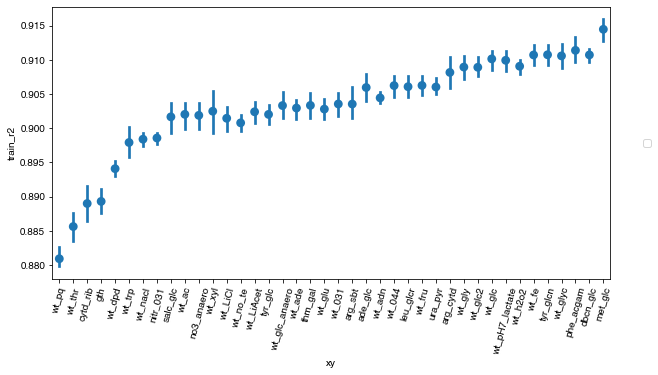

In [46]:
_, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(x='xy', y='train_r2', data=result_df.sort_values(by='train_r2'), dodge=True, ax=ax, join=False)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.tick_params(axis='x', rotation=75)

No handles with labels found to put in legend.


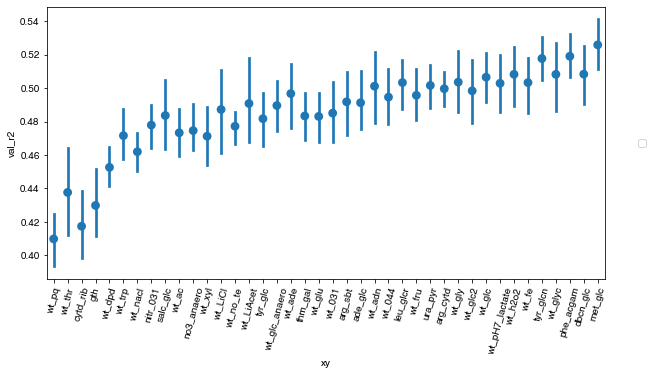

In [48]:
_, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(x='xy', y='val_r2', data=result_df.sort_values(by='train_r2'), dodge=True, join=False, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.tick_params(axis='x', rotation=75)

In [28]:
pd.set_option('display.max_columns', 500)

In [29]:
metadata_df[metadata_df['condition_id'] == 'met_glc']

,sample_id,study,project_id,condition_id,rep_id,contact,creator,run_date,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,Trace Element Mixture,Supplement,Temperature (C),pH,Antibiotic for selection,Culture Type,Growth Rate (1/hr),Evolved Sample,Isolate Type,Sequencing Machine,Additional Details,Biological Replicates,R1,R2,BAM,alignment,DOI,GEO,Published,SRX,Run,Notes,LibraryLayout,Platform,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation,full_name,passed_similar_replicates,passed_number_replicates
ecoli_00181,ica__met_glc__1,ICA,ica,met_glc,1,Anand Sastry,Ying Hefner,12/10/17,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,methionine (5mM),37,7.0,NaN,Batch,0.74,No,NaN,HiSeq 4000,NaN,2,NaN,NaN,ica__met_glc__1.bam,95.45,NaN,GSE122295,1.0,SRX4993792,SRR8173239,NaN,PAIRED,ILLUMINA,True,True,True,True,ica:met_glc,True,True
ecoli_00182,ica__met_glc__2,ICA,ica,met_glc,2,Anand Sastry,Ying Hefner,12/10/17,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,methionine (5mM),37,7.0,NaN,Batch,0.74,No,NaN,HiSeq 4000,NaN,2,NaN,NaN,ica__met_glc__2.bam,95.65,NaN,GSE122295,1.0,SRX4993793,SRR8173240,NaN,PAIRED,ILLUMINA,True,True,True,True,ica:met_glc,True,True
